In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
import time
from gym.envs.registration import register
from IPython.display import clear_output

In [2]:
env = gym.make('CartPole-v1')
print('observation_space:', env.observation_space)
print('action_space:', env.action_space)

observation_space: Box(4,)
action_space: Discrete(2)


In [3]:
class DQN():
    def __init__(self, state_size, action_size, learning_rate=0.0005):
        self.model = self.build(state_size, action_size, learning_rate)
    
    def build(self, state_size, action_size, learning_rate):
        inputs = tf.keras.Input(shape=(state_size,))
        x = inputs
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        outputs = tf.keras.layers.Dense(action_size, activation='linear')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        
        model.compile(loss='mse', optimizer=optimizer)
        
        return model
        
    def get_q_values(self, states):
        return np.array(self.model.predict_on_batch(np.array(states)))
    
    def update(self, states, q_targets, verbose=0):
        self.model.train_on_batch(np.array(states), np.array(q_targets))
        

In [4]:
from collections import deque

class ReplayBuffer():
    def __init__(self, maxlen=1):
        self.buffer = deque(maxlen=maxlen)
        
    def memorize(self, experience):
        self.buffer.append(experience)
        
    def replay(self, size=1):
        if size > len(self.buffer):
            size = len(self.buffer)
        return random.sample(self.buffer, size)
    

In [5]:
class DQNAgent():
    def __init__(self, env):
        # env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        
        # dqn
        self.model = DQN(self.state_dim, self.action_dim)
        
        # epsilon
        self.eps_decay = 0.99
        self.eps_min = 0.05
        self.eps_max = 1.0
        self.eps = self.eps_max
        
        # bellman
        self.gamma = 0.99
        
        self.replay_buffer = ReplayBuffer(1000000)
        
    def get_states(self, states):
        pass
        
    def get_actions(self, states):
        q_values = self.model.get_q_values(states)
        
        actions_random = np.random.randint(self.action_dim, size=len(states))
        actions_greedy = np.argmax(q_values, axis=1)
        
        actions = [r if random.random() < self.eps else g for r, g in zip(actions_random, actions_greedy)]
        return actions
    
    def train(self, experience):
        self.replay_buffer.memorize(experience)
        if len(self.replay_buffer.buffer) < 64:
            return
        
        samples = self.replay_buffer.replay(64)
        
        states, actions, next_states, rewards, dones = zip(*samples)
        
        targets = self.model.get_q_values(states)
        next_q_values = self.model.get_q_values(next_states)
        
        for i in range(len(states)):
            if dones[i]:
                target = rewards[i]
            else:
                target = rewards[i] + self.gamma * np.amax(next_q_values[i])
            targets[i, actions[i]] = target
        
        self.model.update(states, targets)
        
        self.eps = max(self.eps_min, self.eps_decay * self.eps)


In [6]:
num_runs = 1
run_rewards = []

for n in range(num_runs):
    print("Run {}".format(n))
    ep_rewards = []
    agent = None
    agent = DQNAgent(env)
    num_episodes = 200

    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_actions([state])[0]
            next_state, reward, done, info = env.step(action)
            experience = (state, action, next_state, reward, done)
            agent.train(experience)
            #env.render()
            total_reward += reward
            state = next_state

        ep_rewards.append(total_reward)
        print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
        #clear_output(wait=True)
        
    run_rewards.append(ep_rewards)

Run 0
Episode: 0, total_reward: 20.00
Episode: 1, total_reward: 18.00
Episode: 2, total_reward: 17.00
Episode: 3, total_reward: 12.00
Episode: 4, total_reward: 26.00
Episode: 5, total_reward: 20.00
Episode: 6, total_reward: 10.00
Episode: 7, total_reward: 14.00
Episode: 8, total_reward: 9.00
Episode: 9, total_reward: 11.00
Episode: 10, total_reward: 13.00
Episode: 11, total_reward: 9.00
Episode: 12, total_reward: 10.00
Episode: 13, total_reward: 12.00
Episode: 14, total_reward: 10.00
Episode: 15, total_reward: 16.00
Episode: 16, total_reward: 11.00
Episode: 17, total_reward: 11.00
Episode: 18, total_reward: 8.00
Episode: 19, total_reward: 9.00
Episode: 20, total_reward: 10.00
Episode: 21, total_reward: 10.00
Episode: 22, total_reward: 10.00
Episode: 23, total_reward: 10.00
Episode: 24, total_reward: 37.00
Episode: 25, total_reward: 15.00
Episode: 26, total_reward: 47.00
Episode: 27, total_reward: 78.00
Episode: 28, total_reward: 77.00
Episode: 29, total_reward: 34.00
Episode: 30, total

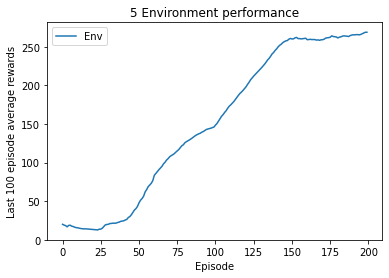

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

for n, ep_rewards in enumerate(run_rewards):
    x = range(len(ep_rewards))
    cumsum = np.cumsum(ep_rewards)
    avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
    plt.plot(x, avgs, label="Env")
    
plt.title("5 Environment performance")
plt.xlabel("Episode")
plt.ylabel("Last 100 episode average rewards")
plt.legend()

In [8]:
env.close()